In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

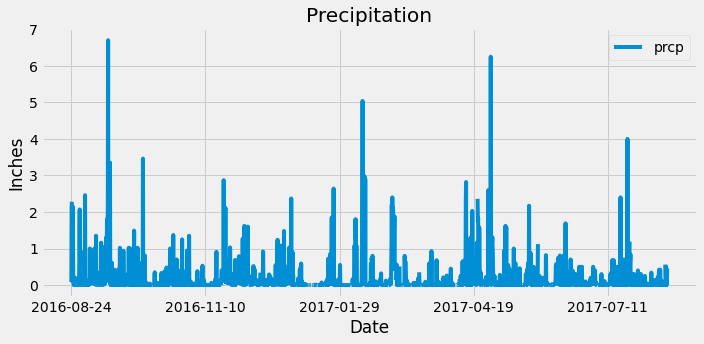

In [9]:
# Find the most recent date in the data set
latest_date = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())

# Design a query to retrieve the last 12 months of precipitation data and plot the results 
# Starting from the most recent data point in the database
latest_date = list(np.ravel(latest_date))[0]

# Calculate the date one year from the last date in data set
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_date = int(dt.datetime.strftime(latest_date, '%d'))

#calculate one year before latest date
yearBefore = dt.date(latest_year, latest_month, latest_date) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > yearBefore)
            .order_by(Measurement.date).all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame(precipitation_scores)
precipitation_data = precipitation_data.set_index("date")

# Sort the dataframe by date
precipitation_data = precipitation_data.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

figure, ax = plt.subplots(figsize = (10, 5))
precipitation_data.plot(ax = ax, x_compat = True)

#title and labels
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.set_title("Precipitation")

plt.savefig("Images/precipitation.png")

#plot
plt.tight_layout()
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(Station.id).distinct().count()
number_stations

9

In [12]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc()).all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Most active station
most_active_station = active_stations[0][0]
most_active_station_name = (session.query(Station.name).filter_by(station = most_active_station))
most_active_station_name = most_active_station_name[0][0]
print(f"Most active station {most_active_station}: {most_active_station_name}")

Most active station USC00519281: WAIHEE 837.5, HI US


In [14]:
# Lowest temperature
lowest_temperature = (session.query(Measurement.tobs)
                     .filter(Measurement.station == most_active_station).order_by(Measurement.tobs.asc()).first())
lowest_temperature = lowest_temperature[0]
print(f"The lowest temperature there is {lowest_temperature} F")

The lowest temperature there is 54.0 F


In [15]:
# Highest temperature
highest_temperature = (session.query(Measurement.tobs).filter(Measurement.station == most_active_station)
                       .order_by(Measurement.tobs.desc()).first())
highest_temperature = highest_temperature[0]
print(f"The highest temperature is {highest_temperature} F")

The highest temperature is 85.0 F


In [16]:
# Average temperature
average_temperature = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station))
average_temperature = '{0:.3}'.format(average_temperature[0][0])
print(f"The average temperature is {average_temperature} F")

The average temperature is 71.7 F


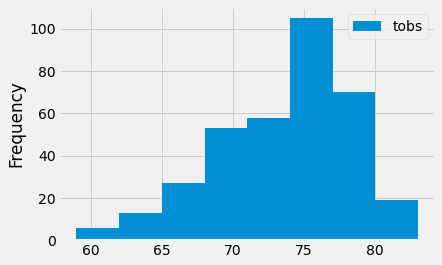

In [17]:
# # Using the most active station id
# # Query the last 12 months of temperature observation data for this station and plot the results as a histogram


last_year_temperature = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == most_active_station).order_by(Measurement.date).all())

# # Conersion of query object into Data frame
temperature = pd.DataFrame(last_year_temperature)
temperature = temperature.set_index("date")


# # Sorting the data by date
temperature = temperature.sort_index(ascending=True)

# # Plotting the results as a histogram
temperature.plot(kind="hist", bins= 8)

# Close session

In [18]:
# Close Session
session.close()